In [1]:
import lichess.api
from pprint import pprint
from datetime import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# working dir should be chessanalytics/src when the notebook starts
while(not os.getcwd().endswith('chess-analytics')):
    os.chdir('..')
print('Working dir: ', os.getcwd())

name = 'carequinha'
user = lichess.api.user(name)

Working dir:  /home/jorge/GIT/chess-analytics


In [2]:
# %reload_ext autoreload
# %autoreload 2

In [190]:
from src.game import ChessGame
from src.get_games import download_games
# download_games('carequinha',
#                         is_rated=True)
# download games if they don't exist
# games = load_games('resources/PGN_database')
games = ChessGame.load_pgn_file('src/resources/'+ name +'.pgn')

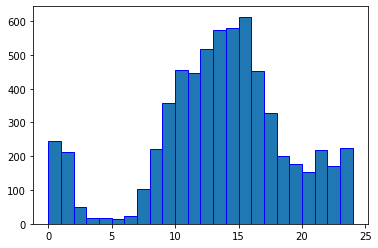

In [218]:
hours = list(map(lambda game: game.utctime.split(':')[0], games))
data_list = list(map(lambda s: int(s), hours))
list_set = set(data_list)
list_set.add(max(list_set)+1)
plt.hist(data_list, bins = list(list_set), edgecolor='blue')
plt.show()

In [6]:
def get_result_list(game_list):
    list_result = list(map(lambda game: game.get_result(name), game_list))
    return {el: list_result.count(el) for el in set(list_result)}

def parse_time(game):
    year = game.date.split('.')[0]
    month = game.date.split('.')[1]
    return float(year) + float(month)/12 - 1/12

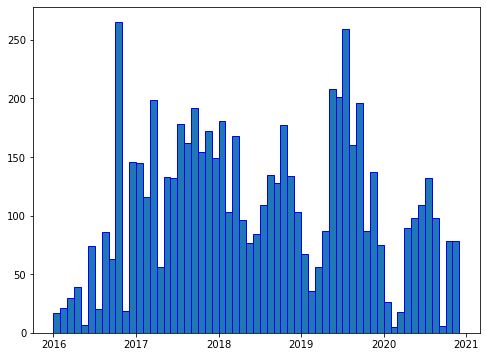

In [217]:
dates = list(map(lambda game: parse_time(game), games))
bins = list(set(dates))
bins.sort()
bins.append(2*bins[-1] - bins[-2])
plt.figure(figsize=(8,6))
plt.hist(dates, bins = bins, edgecolor='blue')
plt.show()

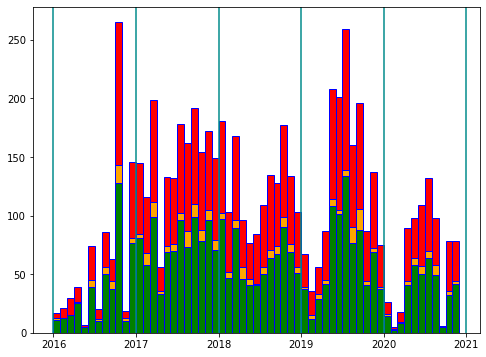

In [7]:
from functools import reduce
def split_list(pattern, base_list):
    values = set([pattern(el) for el in base_list])
    return [[y for y in base_list if pattern(y) == x]for x in values]

def count(pattern, base_list):
    splited_list = split_list((lambda game: pattern(game)), base_list)
    return {pattern(sublist[0]): len(sublist) for sublist in splited_list}

def proportion(a_dict, b_dict):
    div = lambda x,y: float(x)/float(y)
    return merge_dict(div, a_dict, b_dict, lambda x:0)

def merge_dict(pattern, dict1, dict2, exception_pattern = lambda x:x):
    dict3 = {**dict1, **dict2}
    for k, v in dict3.items():
        if k in dict1 and k in dict2:
            dict3[k] = pattern(dict1[k], dict2[k])
        else:
            dict3[k] = exception_pattern(dict3[k])
    return dict3

results = ['WIN','DRAW','LOSS']
colors = {'WIN':'green','DRAW': 'orange','LOSS': 'red'}

split_game_dict = {el: list(filter(lambda game: game.get_result(name) == el, games)) for el in results}
game_counts_dict = {k: count(parse_time, v) for (k,v) in split_game_dict.items()}
key_set = set().union(*(counts.keys() for counts in game_counts_dict.values()))
base_dict = dict.fromkeys(key_set, 0)
game_counts_dict = {k: merge_dict(lambda x,y: x+y, base_dict, counts) for k,counts in game_counts_dict.items()}



sum = lambda a,b: a+b
totals = dict(reduce(lambda dict_a, dict_b : merge_dict(sum, dict_a, dict_b) , list(game_counts_dict.values())))

game_proportion_dict = {k: proportion(v, totals) for k,v in game_counts_dict.items()}

plt.figure(figsize=(8,6))

bot = [0]*len(game_counts_dict['WIN'])
for r, p in game_counts_dict.items():
    pairs = sorted(p.items())
    x = [v[0] for v in pairs]
    top = [v[1] for v in pairs]

    plt.bar(x, top, width=1/12, bottom = bot, edgecolor='blue',color = colors[r], align = 'edge')
    bot = [sum(a,b) for a,b in zip(bot,top)]

v_lines = list(set([int(v) for v in list(base_dict.keys())]))
v_lines.append(2*v_lines[-1] - v_lines[-2])
for line in v_lines:
    plt.axvline(line, color = 'darkcyan')
plt.show()

In [ ]:
import chess
def print_board_at_move(move_list,
                        move_num: int,
                        player: str):
#move_list = (games[1]['moves'].split())
#move_num = 2
#player = 'black'#'white'
    board = chess.Board()
    board.reset()
    if player is 'white' or player is 'w':
        player_move = 0
    elif player is 'black' or player is 'b':
        player_move = 1
    else:
        raise Exception('No proper input for player.')
    for index in range(2*(move_num-1) + player_move):
        move = move_list.pop(0)
        board.push_san(move)
    return board

In [ ]:
board = print_board_at_move(move_list = (games[0].moves), move_num = 1, player = 'b')
board

In [ ]:
from matplotlib.pyplot import plot
plot([0,1],[0,2])
print(len(games))

In [9]:
def get_month_year(game):
    year = game.date.split('.')[0]
    month = game.date.split('.')[1]
    return np.datetime64(year+'-'+format(int(month), '02d'))

import datetime
import calendar

def add_months(sourcedate, months = 1):
    month = sourcedate.astype(object).month -1 + months
    year = sourcedate.astype(object).year + month // 12
    month = month%12 + 1
    return np.datetime64(str(year)+'-'+format(month, '02d'))

def dict_to_list(d):
    dictlist = []
    for k, v in d.items():
        temp = [k,v]
        dictlist.append(temp)
    dictlist.sort(key=lambda x: x[0])
    return dictlist

alt_date = add_months(np.datetime64('2020-01-01'),1)
print(alt_date)

di = {1: 3, -1: 0}
print(dict_to_list(di))

2020-02
[[-1, 0], [1, 3]]


array (date, result)
grouping by result
grouping by date
count

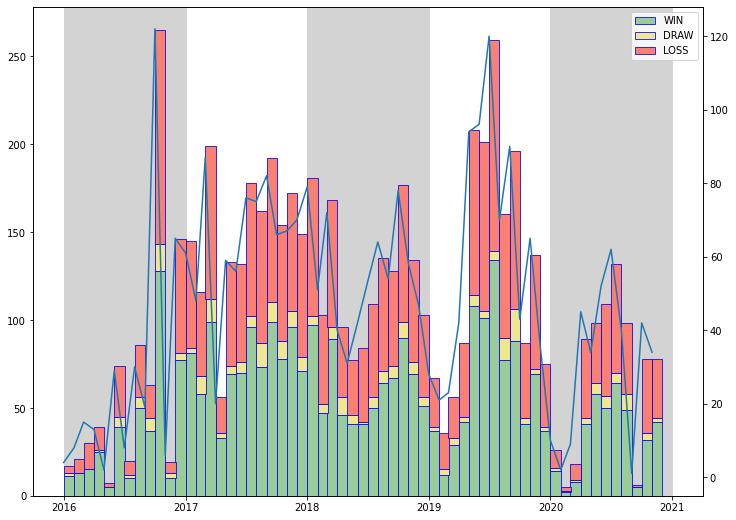

In [268]:
def array_reshaped_to_n_columns(data, n_point):
    return np.reshape(
        data[:data.size - (data.size % n_point)],
        (-1, n_point)
    )

def get_month_year(game):
    return np.datetime64(game.date.replace('.','-'),'M')

colors = {'WIN':[.6,.8,.6],
          'DRAW': 'khaki',
          'LOSS': 'salmon'}

month = np.timedelta64(1,'M')
year = np.timedelta64(1,'Y')

def date_result_array(game_list, funcs, arg_labels=('X','Y','Z')):
    v_funcs = [np.vectorize(func) for func in funcs]
    temp = [func(game_list) for func in v_funcs]

    dtype = [(arg, arr.dtype) for arr, arg in zip(temp, arg_labels)]
    game_results = np.empty(len(game_list), dtype=dtype)

    for arr, arg in zip(temp, arg_labels):
        game_results[arg] = arr
    return game_results

game_results = date_result_array(games,
                                 [get_month_year,
                                 lambda x: x.get_result(name)])

unique_months = np.arange(min(game_results['X']), max(game_results['X'] + month))
monthly_results = np.zeros(len(unique_months),
                           dtype=[('DATE','datetime64[M]'),
                                  ('WIN', 'u4'),
                                  ('DRAW', 'u4'),
                                  ('LOSS', 'u4')])

monthly_results['DATE'] = unique_months
for n, month in enumerate(unique_months):
    for result in colors:
        monthly_results[n][result] = np.sum((game_results['X'] == month) &
                                            (game_results['Y'] == result))

bottom = np.zeros(len(unique_months))
plt.figure(figsize=(12,9))

unique_years = np.unique(unique_months.astype('datetime64[Y]'))
unique_years = np.hstack((unique_years, max(unique_years)+year))
unique_years = array_reshaped_to_n_columns(unique_years, 2)

for year_start, year_finish in unique_years.reshape((-1,2)):
    plt.axvspan(year_start, year_finish, color = 'lightgrey')

for k in colors:
    x = monthly_results['DATE']
    y = monthly_results[k]
    plt.bar(x, y ,label=k, width=1, bottom=bottom,
            color=colors[k],
            align='edge', edgecolor='blue', linewidth=0.8)
    bottom += y

plt.legend()
ax = plt.twinx()
#ax.plot(x,y)
plt.plot(x,y)
plt.show()